In [1]:
from pyspark.sql import SparkSession

In [18]:
from pyspark.ml.stat import Correlation

In [39]:
import seaborn as sns

In [65]:
from matplotlib import pyplot as plt

In [2]:
spark = SparkSession.builder.master('local').getOrCreate()

In [6]:
df = spark.read.option("header","true").csv('bestsellers with categories.csv')

### Print the first 5 rows

In [98]:
df.show(5)

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
only showing top 5 rows



In [77]:
print((df.count(), len(df.columns)))

(550, 7)


### Print the schema 

In [8]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Genre: string (nullable = true)



In [10]:
df.select(df['Name'], df['User Rating'] + 1).show(5)

+--------------------+-----------------+
|                Name|(User Rating + 1)|
+--------------------+-----------------+
|10-Day Green Smoo...|              5.7|
|   11/22/63: A Novel|              5.6|
|12 Rules for Life...|              5.7|
|1984 (Signet Clas...|              5.7|
|5,000 Awesome Fac...|              5.8|
+--------------------+-----------------+
only showing top 5 rows



### cast into float type

In [35]:
from pyspark.sql.types import FloatType

df2 = df.withColumn("User Rating", df["User Rating"].cast(FloatType())).withColumn("Reviews", df["Reviews"].cast(FloatType())).withColumn("Price", df["Price"].cast(FloatType()))


In [36]:
df2.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: float (nullable = true)
 |-- Reviews: float (nullable = true)
 |-- Price: float (nullable = true)
 |-- Year: string (nullable = true)
 |-- Genre: string (nullable = true)



In [44]:
df2.createOrReplaceTempView("books")

### use SQL query 

In [49]:
spark.sql('select * from books limit 5').show()

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|17350.0|  8.0|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6| 2052.0| 22.0|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|18979.0| 15.0|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|21424.0|  6.0|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8| 7665.0| 12.0|2019|Non Fiction|
+--------------------+--------------------+-----------+-------+-----+----+-----------+



### Number of reviews per price 

Text(0.5, 1.0, 'scatter plot')

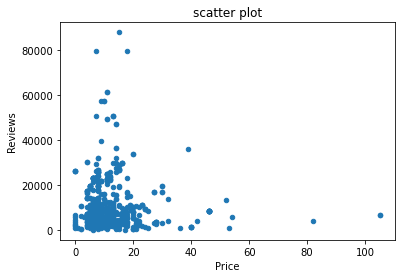

In [72]:
df2.toPandas().plot(kind = 'scatter', x = 'Price', y = 'Reviews')
plt.title('scatter plot')

Text(0, 0.5, 'Reviews')

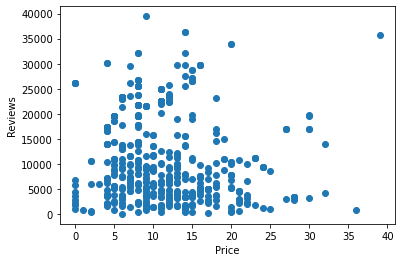

In [214]:
plt.scatter(df2.filter((df2['Price']<40)&(df2['Reviews']< 40000)).select(df2['Price']).toPandas(),
            df2.filter((df2['Price']<40)&(df2['Reviews']< 40000)).select(df2['Reviews']).toPandas())
plt.xlabel('Price')
plt.ylabel('Reviews')

In [227]:
df2.groupBy('Author').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|              Author|count|
+--------------------+-----+
|         Jeff Kinney|   12|
|        Rick Riordan|   11|
|     Suzanne Collins|   11|
|        Gary Chapman|   11|
|American Psycholo...|   10|
|              Gallup|    9|
|           Dr. Seuss|    9|
|         Rob Elliott|    8|
|     Stephenie Meyer|    7|
|       Bill O'Reilly|    7|
|          Dav Pilkey|    7|
|          Eric Carle|    7|
|    Stephen R. Covey|    7|
|         Sarah Young|    6|
|           E L James|    6|
|   The College Board|    6|
|       Stieg Larsson|    6|
|          Harper Lee|    6|
|     Don Miguel Ruiz|    6|
|        J.K. Rowling|    6|
+--------------------+-----+
only showing top 20 rows



In [131]:
dfp = df2.groupby('Price').mean().orderBy('Price')

Text(0.5, 1.0, 'Average (User Rating) of books per price')

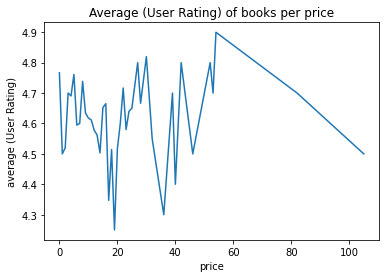

In [129]:
plt.plot(list(map(lambda x: int(x) , dfp.select(dfp['Price']).toPandas()['Price'].values.tolist())), 
         dfp.select(dfp['avg(User Rating)']).toPandas())
plt.xlabel('price')
plt.ylabel('average (User Rating)')
plt.title('Average (User Rating) of books per price')

Text(0, 0.5, 'Nb of occurences')

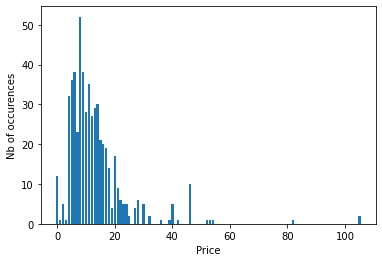

In [251]:
plt.bar(df2.groupby('Price').count().orderBy('Price').select('Price').toPandas()['Price'].values,
        df2.groupby('Price').count().orderBy('Price').select('count').toPandas()['count'].values)
plt.xlabel('Price')
plt.ylabel('Nb of occurences')

### User Rating distribution for fiction vs non fiction 

CPU times: user 76.1 ms, sys: 6.2 ms, total: 82.3 ms
Wall time: 247 ms


Text(0.5, 1.0, 'User Rating : Fiction Vs Non Fiction')

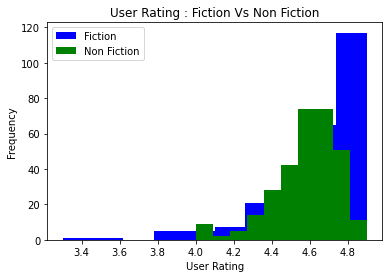

In [71]:
%%time
df2.select(df2['User Rating'], df2['Genre']).filter(df2['Genre']=='Fiction').toPandas()['User Rating'].plot(kind='hist',color = 'blue',label='Fiction')
df2.select(df2['User Rating'], df2['Genre']).filter(df2['Genre']=='Non Fiction').toPandas()['User Rating'].plot(kind='hist',color = 'green',label='Non Fiction')
plt.xlabel('User Rating')
plt.legend(loc='best')
plt.title('User Rating : Fiction Vs Non Fiction')

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='User Rating', ylabel='Density'>

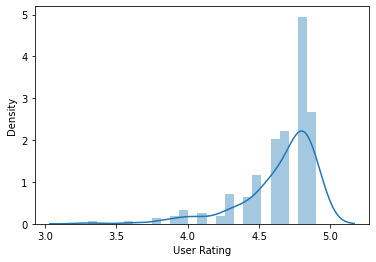

In [133]:
sns.distplot(df2.select(df2['User Rating'], df2['Genre']).filter(df2['Genre']=='Fiction').toPandas()['User Rating'])

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='User Rating', ylabel='Density'>

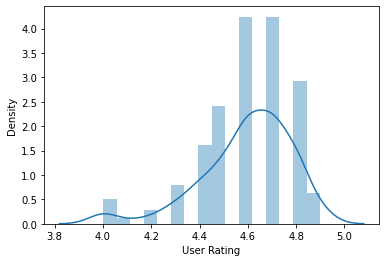

In [134]:
sns.distplot(df2.select(df2['User Rating'], df2['Genre']).filter(df2['Genre']=='Non Fiction').toPandas()['User Rating'])

In [125]:
dfe = df2.groupby('Year').mean().orderBy('Year')

### Average Price , reviews, User ratings per year 

Text(0.5, 1.0, 'Average price of books per year')

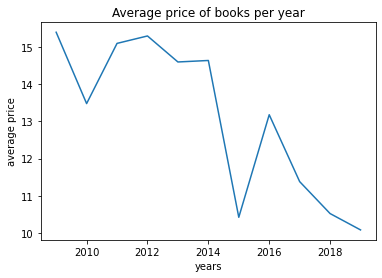

In [121]:
plt.plot(list(map(lambda x: int(x) , dfe.select(dfe['Year']).toPandas()['Year'].values.tolist())), 
         dfe.select(dfe['avg(Price)']).toPandas())
plt.xlabel('years')
plt.ylabel('average price')
plt.title('Average price of books per year')

Text(0.5, 1.0, 'avg(Reviews) of books per year')

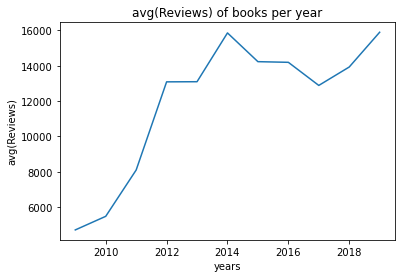

In [123]:

plt.plot(list(map(lambda x: int(x) , dfe.select(dfe['Year']).toPandas()['Year'].values.tolist())), 
         dfe.select(dfe['avg(Reviews)']).toPandas())
plt.xlabel('years')
plt.ylabel('avg(Reviews)')
plt.title('avg(Reviews) of books per year')

Text(0.5, 1.0, 'avg(User Rating) of books per year')

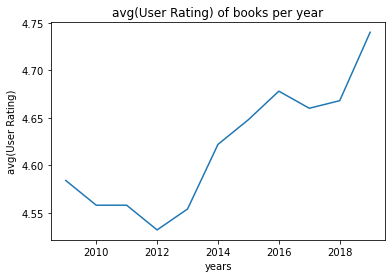

In [124]:
plt.plot(list(map(lambda x: int(x) , dfe.select(dfe['Year']).toPandas()['Year'].values.tolist())), 
         dfe.select(dfe['avg(User Rating)']).toPandas())
plt.xlabel('years')
plt.ylabel('avg(User Rating)')
plt.title('avg(User Rating) of books per year')

In [ ]:
# MLLIb

In [157]:
df2 = df.withColumn("User Rating", df["User Rating"].cast(FloatType())).withColumn("Reviews", df["Reviews"].cast(FloatType())).withColumn("Price", df["Price"].cast(FloatType())).withColumn("Year", df["Year"].cast(FloatType()))

In [158]:
df2.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: float (nullable = true)
 |-- Reviews: float (nullable = true)
 |-- Price: float (nullable = true)
 |-- Year: float (nullable = true)
 |-- Genre: string (nullable = true)



In [197]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression
from pyspark.ml.feature import VectorIndexer, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator


featureIndexer = StringIndexer(inputCol="Author", outputCol="AuthorIndex").fit(df2)

assembler = VectorAssembler(
    inputCols=["User Rating", "Price", "AuthorIndex","Year"],
    outputCol="Features")
dt = LinearRegression(featuresCol="Features", labelCol="Reviews")
pipeline = Pipeline(stages=[featureIndexer,assembler, dt])
(trainingData, testData) = df2.randomSplit([0.7, 0.3])


In [207]:
VectorAssembler(inputCols=["User Rating", "Price","Year"],outputCol="Features").transform(df2).select("Features").show(10, False)

+-------------------------------+
|Features                       |
+-------------------------------+
|[4.699999809265137,8.0,2016.0] |
|[4.599999904632568,22.0,2011.0]|
|[4.699999809265137,15.0,2018.0]|
|[4.699999809265137,6.0,2017.0] |
|[4.800000190734863,12.0,2019.0]|
|[4.400000095367432,11.0,2011.0]|
|[4.699999809265137,30.0,2014.0]|
|[4.699999809265137,15.0,2017.0]|
|[4.699999809265137,3.0,2018.0] |
|[4.599999904632568,8.0,2016.0] |
+-------------------------------+
only showing top 10 rows



In [198]:
model = pipeline.fit(trainingData)
predictions_training = model.transform(trainingData)

In [199]:
predictions_test = model.transform(testData)

In [255]:
from pyspark.mllib.evaluation import RegressionMetrics

In [258]:
metrics = RegressionMetrics(predictions_test.select('prediction','Reviews').rdd.map(tuple))

In [259]:
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# R-squared
print("R-squared = %s" % metrics.r2)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

# Explained variance
print("Explained variance = %s" % metrics.explainedVariance)

MSE = 225114792.60601807
RMSE = 15003.825932275344
R-squared = 0.0164406752732148
MAE = 8882.953762735246
Explained variance = 25307734.165502466


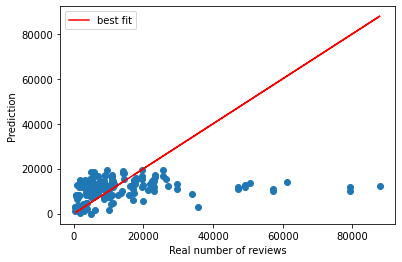

In [263]:
plt.scatter(predictions_test.select('Reviews').toPandas(),
            predictions_test.select('prediction').toPandas())
plt.plot(predictions_test.select('Reviews').toPandas(), predictions_test.select('Reviews').toPandas(), c='r', label='best fit')
plt.xlabel('Real number of reviews')
plt.ylabel('Prediction')
plt.legend()